## Make a mineral fertility map from point data, based on min.sep. weight percentages

### Import libraries

In [4]:
import numpy as np                                 # library for arrays 
import pandas as pd                                # library for tables 
import geopandas as gpd                            # library for georeferenced tables 
from collections import OrderedDict                # ordered dictionary objects
import matplotlib.pyplot as plt                    # plotting library
import matplotlib.gridspec as gs                   # library to make gridded subplots
from matplotlib.pyplot import cm                   # colour management liibrary
import seaborn as sns                              # pretty statistical plotting library
import scipy.interpolate as intr                   # interpolation functions
from sklearn.linear_model import LinearRegression  # linear regression function
import utm                                         # conversion from and to UTM coordinates
from os import mkdir, path                         # operating system utilities
from ESD_thermotrace_functions import *            # custom functions

# this command displays plots below the related cell
%matplotlib inline

# # Alternatively, this command makes matplotlib open an interactive window everytime a figure is produced
# %matplotlib notebook 

sns.set(style='white', context='talk') # all plots have white background and large fontsize

### Specify input files and parameters

In [25]:
# input and output folders
ipf = '/Users/andrea/Documents/docs/src/Python/ESD_thermotrace/input/'
opf = '/Users/andrea/Documents/docs/src/Python/ESD_thermotrace/output/'

# Input bedrock ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd, fertility

bedrock_ages_filename = 'bedrock_data_clean_fertility.xlsx'
# List of input detrital ages filenames, with .xlsx extension
# These should be a table with at least 2 columns with following headers: age, age_u
# where age_u = analytical uncertainty
detrital_ages_filenames = ['detrital_data.xlsx']

# dem of study area
dem_filename = 'dem.txt' # digital elevation model

# watershed of catchment
ws_filename = 'ws_lc.shp'

# Input target resolution of the interpolated surface [meters]
res = 500  

# What interpolation method do you want?
# Options are:
# 'rbf' - linear Radial Basis Function --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
# 'int' - 3D linear interpolation --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
# 'ext' - like 'int', but additionally extrapolates ages outside of the interpolation convex hull (see below)
# 'zln' - each z gets assigned an age based on a linear regression of age-elevation data.
# 'imp' - import your own interpolated age map and uncertainty map (ASCII files referenced in WGS1984)
interp_method = 'rbf'

# # If 'ext' is chosen, an inverse-distance-weight is used to assign ages
# # to the cells out of the linear interpolation field, but not farther than the search radius 'ext_rad'
# # which search radius do you want?
# # comment this line if not needed
# ext_rad = 10000 # meters

### Import input files and display them

In [26]:
########################## Open DEM and read the metadata ################################
##########################################################################################
        
dem = DEM('topography')
dem.from_ascii(ipf+'/'+dem_filename)
dem.info()


METADATA OF topography

xllcorner = -71.200416424533
yllcorner = -33.000416206563
ncols = 241
nrows = 121
cellsize [km] = 0.000833333333
cellsize [m] = ~90
min value = 137.0
max value = 2218.0
NODATA_value = nan


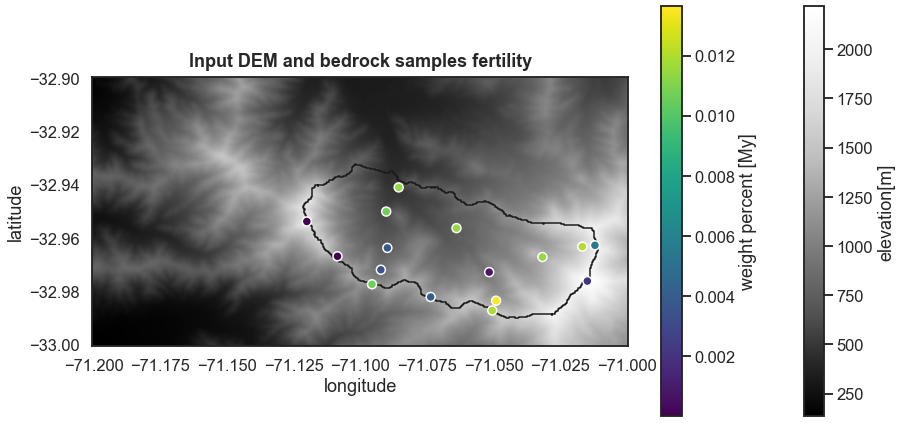

In [27]:
bd = pd.read_excel(ipf+'/'+bedrock_ages_filename)
bd.sort_values(by='elev',inplace=True)
z = bd.elev.values
if z.mean()<10:
    z = z*1000 # convert elevations from km to meters, if that's the case
a = bd.age.values
u = bd.sd.values
lat = bd.lat.values
lon = bd.lon.values


# convert from geographic to projected coordinates,
# otherwise the interpolation will overestimate the role of elevation and produce funny results.
# preallocate arrays
x_utm = np.array([])
y_utm = np.array([])
for i,v in enumerate(lat):
    xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
    x_utm = np.append(x_utm, xy_utm[0])
    y_utm = np.append(y_utm, xy_utm[1])

# add points at -5000 m below sample elevation (zero cooling age depth) to arrays
# such that each x,y location has a double with age=0 and elev=z-5000
xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
yy_utm = y_utm
zz = z
aa = a
for i,v in enumerate(z):
    xx_utm = np.append(xx_utm, x_utm[i])
    yy_utm = np.append(yy_utm, y_utm[i])
    zz = np.append(zz, v-5000)
    aa = np.append(aa, 1e-9)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# import watershed outline as geopandas.DataFrame 
ws_outline = gpd.read_file(ipf+'/'+ws_filename)

# make figure, gridspec and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit

fig = plt.figure(figsize=(15,15*dem.nrows/dem.ncols))
gspec = gs.GridSpec(1,1,figure=fig)

# raster plot
ax1 = fig.add_subplot(gspec[0,:]) # first row of plot
im = ax1.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)

ax1.set(aspect='equal', xlabel='longitude', ylabel='latitude',
        xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))

# colorbar
cb1 = fig.colorbar(im)
cb1.set_label('elevation[m]')

# scatter plot if map of bedrock data was not imported
ax1.set_title('Input DEM and bedrock samples fertility',pad=10, fontdict=dict(weight='bold'))
sct = ax1.scatter(lon, lat, c=bd.fertility, cmap='viridis', edgecolor='w')
cb2 = fig.colorbar(sct)
cb2.set_label('weight percent [My]')

# make output directory
if not path.exists(opf):
    mkdir(opf)

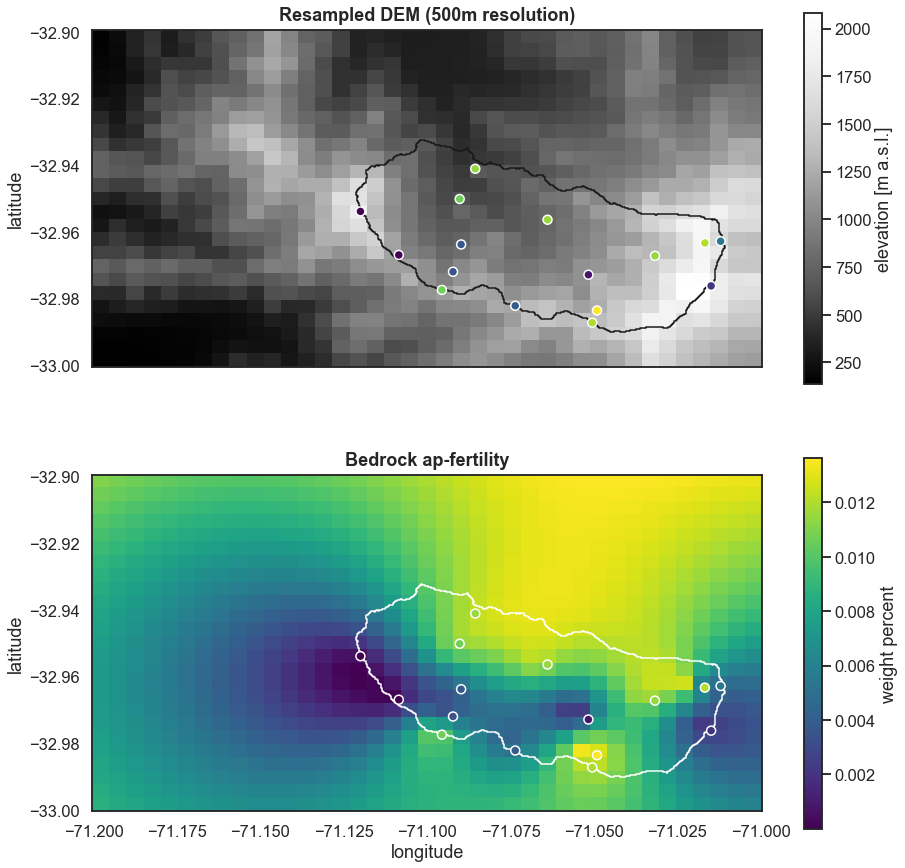

In [28]:
dem.resample(res)

########################## Interpolate fertility data over the spatial extent #######################
####################################################################################################
# Now run interpolation according to chosen method.

rbfi = intr.Rbf(x_utm, y_utm, bd.fertility.values, function='linear')
fert_interp_map = rbfi(dem.xi_res, dem.yi_res)
    
#################################### Plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(dem.zi_res, origin='upper', extent=dem.extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')

ax2 = fig.add_subplot(gspec[1])

# plot bedrock surface age map
im2 = ax2.imshow(fert_interp_map, origin='upper', extent=dem.extent84, cmap='viridis', alpha=1)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Bedrock ap-fertility', pad=10, fontdict=dict(weight='bold'))

# plot samples and ages if interpolated map was not imported at the beginning
vmin = min(np.nanmin(fert_interp_map),bd.fertility.min())
vmax = max(np.nanmax(fert_interp_map),bd.fertility.max())
for ax in [ax1,ax2]:
    ax.scatter(x=lon, y=lat, c=bd.fertility, cmap='viridis', vmin=vmin, vmax=vmax, edgecolor='w')
    ax.set(xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
        
m = cm.ScalarMappable(cmap='viridis')
m.set_clim(vmin, vmax)
cb = fig.colorbar(m)
cb.set_label('weight percent')